In [149]:
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [150]:
# Preprocess the Data: from naivebayes2 (Melvin Adkins work)

lemmatizer = WordNetLemmatizer()

filepath = "finalized_8K_accounts.csv"
hand_label = "hand.label"
government = "gov"
academia = "acad"

df = pd.read_csv(filepath)

df = df[((df[hand_label]=='media') | (df[hand_label]== academia) | (df[hand_label]==government) | (df[hand_label]=='other' ))]


df = df[['username','description',hand_label]] # keep only relevant columns


# Preprocessing step - lemmatization on description column
words_not_changed = ['media']

def preprocessing(row):
    if str(row) == "nan":
        row = ""
    else:
        row = str(row).lower()          # lowercase (so that upper and lowercase words are treated the same)
        row = word_tokenize(row)        # tokenize  (to perform lemmitization)
        row = [lemmatizer.lemmatize(word) if word not in words_not_changed else word for word in row]   # lemmatize
    return str(row)                     # convert back to string


df['description_lemmatized'] = df['description'].apply(preprocessing)


print(df.head())
print()

print(df.head())
print()
print('Number of labels per category:')
print(df[hand_label].value_counts())
print()

       username                                        description hand.label  \
0   Casper30214  Army Civil Service(Retired);Military Ops Resea...      other   
1         enckj  Former EPA Regional Administrator, President o...       acad   
2  nuclearkelly  Scientist at ORNL, DOE Early Career Awardee, F...       acad   
3       stukhan  Dad. Director of the Australian Graduate Schoo...       acad   
4       PatMag7  Podcasting about Feminist Participatory Action...       acad   

                              description_lemmatized  
0  ['army', 'civil', 'service', '(', 'retired', '...  
1  ['former', 'epa', 'regional', 'administrator',...  
2  ['scientist', 'at', 'ornl', ',', 'doe', 'early...  
3  ['dad', '.', 'director', 'of', 'the', 'austral...  
4  ['podcasting', 'about', 'feminist', 'participa...  

       username                                        description hand.label  \
0   Casper30214  Army Civil Service(Retired);Military Ops Resea...      other   
1         enckj  For

In [151]:
# split my data into training, and test sets
scaler = StandardScaler()

X = df['description_lemmatized']
y_labels = df[hand_label]

X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

In [152]:
print("SHAPE:", X_train.shape)

SHAPE: (6281,)


In [153]:
print(X.value_counts())


                                                                                                                                                                                                                                                         1357
['teacher']                                                                                                                                                                                                                                                 3
['.']                                                                                                                                                                                                                                                       3
['she/her']                                                                                                                                                                                                                                   

In [154]:
print(X_train.value_counts())

                                                                                                                                                                                                                                                                                1092
['.']                                                                                                                                                                                                                                                                              3
['she/her']                                                                                                                                                                                                                                                                        3
['teacher']                                                                                                                                                              

In [155]:
print(y_train.value_counts())

other    5785
media     317
acad      150
gov        29
Name: hand.label, dtype: int64


In [156]:
print(y_test.value_counts())

other    1447
media      80
acad       37
gov         7
Name: hand.label, dtype: int64


In [157]:
nan_counts = X_train.isna().sum()
print(nan_counts)

0


In [158]:
nan_counts = y_train.isna().sum()
print(nan_counts)

0


In [159]:
tfidf_transformer = TfidfTransformer()
count_vectorizer = CountVectorizer(stop_words="english")


tfidf_pipeline = Pipeline([
    ('vectorizer', count_vectorizer),
    ('transformer', tfidf_transformer),
    ('normalize', StandardScaler(with_mean=False)),
    ('classifier', SVC())
])

tfidf_param_grid = [
    {
        'vectorizer__min_df': [0.0, 0.01, 0.015, 0.02],
        'transformer__use_idf': [True, False],
        # 'normalize__with_mean': [False],
        'classifier__C': [1.0e-10, 0.5, 2.0, 5.0, 10.0],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__class_weight': ["balanced"]
    }
]

In [160]:
count_vectorizer = CountVectorizer(stop_words="english")

bag_of_words_pipeline = Pipeline([
    ('vectorizer', count_vectorizer),
    ('normalize', StandardScaler(with_mean=False)),
    ('classifier', SVC())
])

bag_of_words_param_grid = [
    {
        'vectorizer__min_df': [0.0, 0.01, 0.015, 0.02],
        # 'normalize__with_mean': [False],
        'classifier__C': [1.0e-10, 0.5, 2.0, 5.0, 10.0],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__class_weight': ["balanced"]
    }
]


In [161]:
# Grid Search - TF-IDF
tfidf_grid_search = GridSearchCV(estimator=tfidf_pipeline, param_grid=tfidf_param_grid, cv=5, scoring='accuracy', verbose=1, error_score="raise")

tfidf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('transformer', TfidfTransformer()),
                                       ('normalize',
                                        StandardScaler(with_mean=False)),
                                       ('classifier', SVC())]),
             param_grid=[{'classifier__C': [1e-10, 0.5, 2.0, 5.0, 10.0],
                          'classifier__class_weight': ['balanced'],
                          'classifier__kernel': ['linear', 'poly', 'rbf',
                                                 'sigmoid'],
                          'transformer__use_idf': [True, False],
                          'vectorizer__min_df': [0.0, 0.01, 0.015, 0.02]}],
             scoring='accuracy', verbose=1)

In [162]:
# Bag Of Words
bag_of_words_grid_search = GridSearchCV(estimator=bag_of_words_pipeline, param_grid=bag_of_words_param_grid, cv=5, scoring='accuracy', verbose=1,error_score="raise" )

bag_of_words_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('normalize',
                                        StandardScaler(with_mean=False)),
                                       ('classifier', SVC())]),
             param_grid=[{'classifier__C': [1e-10, 0.5, 2.0, 5.0, 10.0],
                          'classifier__class_weight': ['balanced'],
                          'classifier__kernel': ['linear', 'poly', 'rbf',
                                                 'sigmoid'],
                          'vectorizer__min_df': [0.0, 0.01, 0.015, 0.02]}],
             scoring='accuracy', verbose=1)

In [163]:
tfidf_best_hyperparameters = tfidf_grid_search.best_params_
print("Best TF-IDF SVM ACCURACY:", tfidf_grid_search.best_score_)
print("Best TF-IDF SVM Hyperparameters:", tfidf_best_hyperparameters)

print()

Best TF-IDF SVM ACCURACY: 0.9430024981124809
Best TF-IDF SVM Hyperparameters: {'classifier__C': 0.5, 'classifier__class_weight': 'balanced', 'classifier__kernel': 'linear', 'transformer__use_idf': True, 'vectorizer__min_df': 0.0}



In [164]:
bag_of_words_best_hyperparameters = bag_of_words_grid_search.best_params_
print("Best TF-IDF Bag of Words ACCURACY:", bag_of_words_grid_search.best_score_)
print("Best TF-IDF Bag of Words Hyperparameters:", bag_of_words_best_hyperparameters)

print()

Best TF-IDF Bag of Words ACCURACY: 0.9414106481411103
Best TF-IDF Bag of Words Hyperparameters: {'classifier__C': 5.0, 'classifier__class_weight': 'balanced', 'classifier__kernel': 'sigmoid', 'vectorizer__min_df': 0.0}



In [165]:
# print(tfidf_grid_search.cv_results_)

In [166]:
tfidf_best_SVM_model = tfidf_grid_search.best_estimator_

In [167]:
bag_of_words_best_SVM_model = bag_of_words_grid_search.best_estimator_

In [168]:
tfidf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('transformer', TfidfTransformer()),
                ('normalize', StandardScaler(with_mean=False)),
                ('classifier', SVC())])

In [169]:
bag_of_words_pipeline.set_params(**bag_of_words_grid_search.best_params_)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(min_df=0.0, stop_words='english')),
                ('normalize', StandardScaler(with_mean=False)),
                ('classifier',
                 SVC(C=5.0, class_weight='balanced', kernel='sigmoid'))])

In [170]:
tfidf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('transformer', TfidfTransformer()),
                ('normalize', StandardScaler(with_mean=False)),
                ('classifier', SVC())])

In [171]:
bag_of_words_pipeline.fit(X_train, y_train)


Pipeline(steps=[('vectorizer',
                 CountVectorizer(min_df=0.0, stop_words='english')),
                ('normalize', StandardScaler(with_mean=False)),
                ('classifier',
                 SVC(C=5.0, class_weight='balanced', kernel='sigmoid'))])

In [172]:
# Cross validate
y_pred_tfidf = cross_val_predict(tfidf_best_SVM_model, X_train, y_train, cv=5)

In [173]:
y_pred_bag_of_words = cross_val_predict(bag_of_words_best_SVM_model, X_train, y_train, cv=5)


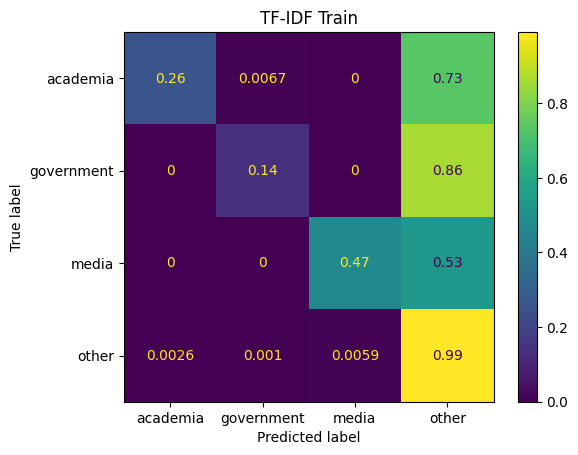

In [174]:
cm = confusion_matrix(y_train, y_pred_tfidf, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['academia', 'government', 'media', 'other'])
disp.plot()

plt.title("TF-IDF Train")
plt.show()

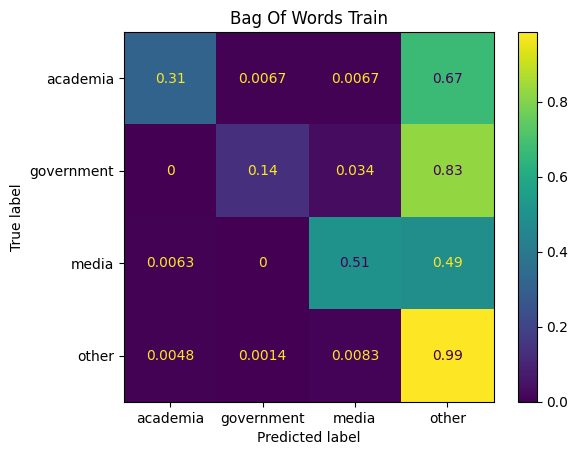

In [175]:
cm = confusion_matrix(y_train, y_pred_bag_of_words, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['academia', 'government', 'media', 'other'])
disp.plot()

plt.title("Bag Of Words Train")
plt.show()

In [176]:
print("TF-IDF Classification Report:")
print(metrics.classification_report(y_train, y_pred_tfidf))

TF-IDF Classification Report:
              precision    recall  f1-score   support

        acad       0.72      0.26      0.38       150
         gov       0.36      0.14      0.20        29
       media       0.82      0.47      0.60       317
       other       0.95      0.99      0.97      5785

    accuracy                           0.94      6281
   macro avg       0.71      0.47      0.54      6281
weighted avg       0.93      0.94      0.93      6281



In [177]:
print("Bag of Words Classification Report:")
print(metrics.classification_report(y_train, y_pred_bag_of_words))

Bag of Words Classification Report:
              precision    recall  f1-score   support

        acad       0.61      0.31      0.41       150
         gov       0.31      0.14      0.19        29
       media       0.76      0.51      0.61       317
       other       0.95      0.99      0.97      5785

    accuracy                           0.94      6281
   macro avg       0.66      0.49      0.55      6281
weighted avg       0.93      0.94      0.93      6281



In [178]:
tfidf_y_pred_test = tfidf_pipeline.predict(X_test)

In [179]:
bag_of_words_y_pred_test = bag_of_words_pipeline.predict(X_test)

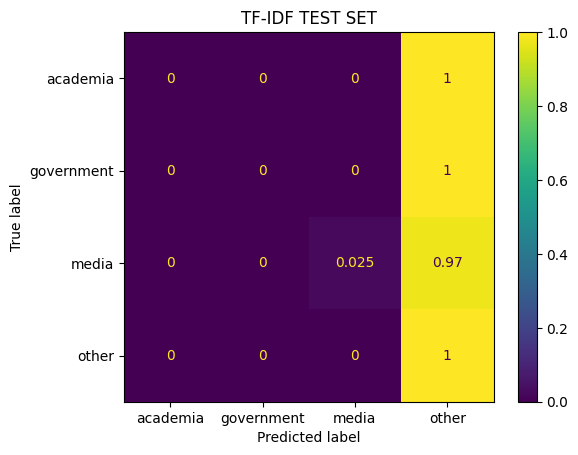

In [180]:
cm = confusion_matrix(y_test, tfidf_y_pred_test, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['academia', 'government', 'media', 'other'])
disp.plot()

plt.title("TF-IDF TEST SET")
plt.show()

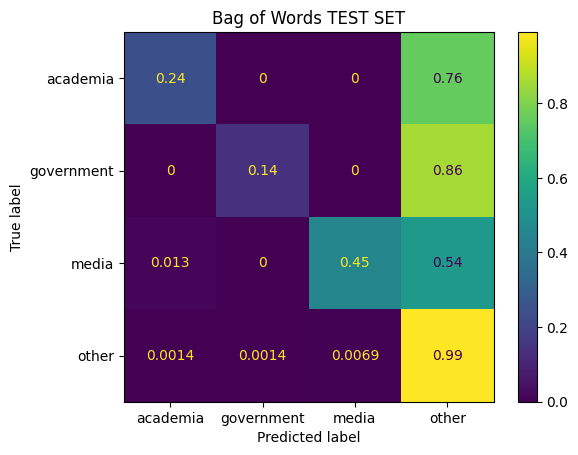

In [181]:
cm = confusion_matrix(y_test, bag_of_words_y_pred_test, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['academia', 'government', 'media', 'other'])
disp.plot()

plt.title("Bag of Words TEST SET")
plt.show()

In [182]:
print("TF-IDF Classification Report TEST:")
print(metrics.classification_report(y_test, tfidf_y_pred_test))
print()

TF-IDF Classification Report TEST:
              precision    recall  f1-score   support

        acad       0.00      0.00      0.00        37
         gov       0.00      0.00      0.00         7
       media       1.00      0.03      0.05        80
       other       0.92      1.00      0.96      1447

    accuracy                           0.92      1571
   macro avg       0.48      0.26      0.25      1571
weighted avg       0.90      0.92      0.89      1571




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [183]:
print("Bag of Words Classification Report TEST:")
print(metrics.classification_report(y_test, bag_of_words_y_pred_test))
print()

Bag of Words Classification Report TEST:
              precision    recall  f1-score   support

        acad       0.75      0.24      0.37        37
         gov       0.33      0.14      0.20         7
       media       0.78      0.45      0.57        80
       other       0.95      0.99      0.97      1447

    accuracy                           0.94      1571
   macro avg       0.70      0.46      0.53      1571
weighted avg       0.93      0.94      0.93      1571


